# Twitter Setiment Analysis using [BERT model](https://huggingface.co/bert-base-uncased)
Sentiment Analysis using [twitter sentiment dataset](https://huggingface.co/datasets/carblacac/twitter-sentiment-analysis) from Hub (binary classification) and [BERT Tokenizer](https://huggingface.co/docs/transformers/v4.21.1/en/model_doc/bert#transformers.BertTokenizer) based on [WordPiece](https://huggingface.co/docs/transformers/tokenizer_summary#wordpiece)<br>


In [ ]:
#Check if GPU is available on notebook
import torch
torch.cuda.is_available()

True

## 1.Download Libraries

In [ ]:
#To clone and upload models
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
!pip install datasets transformers huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 7.5 MB/s 
     |████████████████████████████████| 4.7 MB 65.2 MB/s 
     |████████████████████████████████| 101 kB 15.1 MB/s 
     |████████████████████████████████| 141 kB 48.1 MB/s 
     |████████████████████████████████| 115 kB 75.3 MB/s 
     |████████████████████████████████| 212 kB 69.5 MB/s 
     |████████████████████████████████| 596 kB 71.1 MB/s 
     |████████████████████████████████| 127 kB 59.5 MB/s 
     |████████████████████████████████| 6.6 MB 24.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#For model evaluation metrics
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.7 MB/s 


In [ ]:
#Imports
#Libraries for loading pretrained models and datasets
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
#Libraries for performance evaluation metrics
import numpy as np
from datasets import load_metric
from evaluate import load
#Libraries for fine-tuning model
from transformers import TrainingArguments, Trainer
#Libraries for visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Add your Hugging Face token
from huggingface_hub import notebook_login
notebook_login()

## 2.Load and Preprocess Dataset

In [ ]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"

### 2.1.Load dataset from HuggingFace Datasets

In [ ]:
dataset = load_dataset("carblacac/twitter-sentiment-analysis")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-aa7d06c4a4ef1a07/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/149985 [00:00<?, ?ex/s]

  0%|          | 0/61998 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/119988 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29997 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/61998 [00:00<?, ? examples/s]

Dataset twitter-sentiment-analysis downloaded and prepared to /root/.cache/huggingface/datasets/carblacac___twitter-sentiment-analysis/default/1.0.0/cd65e23e456de6a4f7264e305380b0ffe804d6f5bfd361c0ec0f68d8d1fab95b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'feeling'],
        num_rows: 119988
    })
    validation: Dataset({
        features: ['text', 'feeling'],
        num_rows: 29997
    })
    test: Dataset({
        features: ['text', 'feeling'],
        num_rows: 61998
    })
})

### 2.2.EDA

In [ ]:
train_neg_cnt = len([label for label in dataset['train']['feeling'] if label==0])
valid_neg_cnt = len([label for label in dataset['validation']['feeling'] if label==0])
test_neg_cnt = len([label for label in dataset['test']['feeling'] if label==0])

train_len = len(dataset['train']['feeling'])
valid_len = len(dataset['validation']['feeling'])
test_len = len(dataset['test']['feeling'])

In [ ]:
data = {'split': ['train', 'validation', 'test'],
        'negative': [train_neg_cnt, valid_neg_cnt, test_neg_cnt],
        'positive': [train_len - train_neg_cnt,
                     valid_len - valid_neg_cnt,
                     test_len - test_neg_cnt]
        }

df_eda = pd.DataFrame(data)
df_eda

,split,negative,positive
0,train,59969,60019
1,validation,15050,14947
2,test,30969,31029


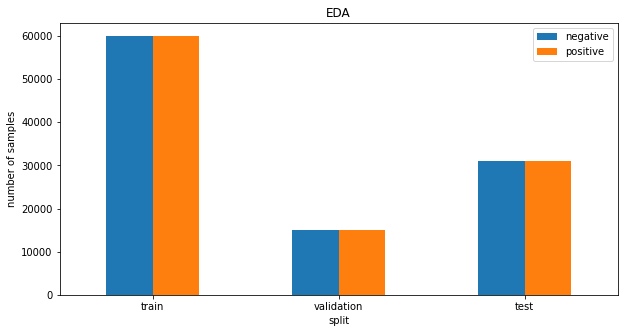

In [ ]:
df_eda.plot.bar(x='split', rot=0, figsize=(10,5))
plt.title('EDA')
plt.xlabel('split')
plt.ylabel('number of samples')
plt.show()

### 2.3.Preprocess Data
- Rename 'feelings' to 'label'
- Apply Tokenizer

In [ ]:
small_train_dataset = dataset["train"].shuffle(seed=42).select([i for i in list(range(5000))])
small_valid_dataset = dataset["validation"].shuffle(seed=42).select([i for i in list(range(500))])
small_test_dataset = dataset["test"].shuffle(seed=42).select([i for i in list(range(1000))])

In [ ]:
small_train_dataset = small_train_dataset.rename_column("feeling", "label")
small_valid_dataset = small_valid_dataset.rename_column("feeling", "label")
small_test_dataset = small_test_dataset.rename_column("feeling", "label")

In [ ]:
small_train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 5000
})

In [ ]:
small_train_dataset[1]

{'label': 1,
 'text': "i feel surprisingly accomplished today  I can't wait to get my blackberry today!!!!! Twitterberry will probably be one of my first tasks!!"}

In [ ]:
#Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
#Sample text for understanding preprocessing
sample_txt = 'She was playing near garden, behind transportation vehicle.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt} \nTokens:{tokens} \nToken ids:{token_ids}')

 Sentence: She was playing near garden, behind transportation vehicle. 
Tokens:['she', 'was', 'playing', 'near', 'garden', ',', 'behind', 'transportation', 'vehicle', '.'] 
Token ids:[2016, 2001, 2652, 2379, 3871, 1010, 2369, 5193, 4316, 1012]


In [ ]:
#Preprocess text in dataset using Tokenizer
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_valid = small_valid_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5000
})

In [ ]:
[print(f"{key}: {val}") for (key,val) in tokenized_train[1].items()]

text: i feel surprisingly accomplished today  I can't wait to get my blackberry today!!!!! Twitterberry will probably be one of my first tasks!!
label: 1
input_ids: [101, 1045, 2514, 10889, 8885, 2651, 1045, 2064, 1005, 1056, 3524, 2000, 2131, 2026, 25935, 2651, 999, 999, 999, 999, 999, 10474, 9766, 2097, 2763, 2022, 2028, 1997, 2026, 2034, 8518, 999, 999, 102]
token_type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[None, None, None, None, None]

In [ ]:
#Convert training samples to PyTorch tensors and concatenate correct amount of padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
data_collator

DataCollatorWithPadding(tokenizer=PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

## 3.Load Pretrained BERT model

In [ ]:
#Removing the pretraining head of BERT model and replacing it with a classification head fine-tuned for sentiment analysis.
model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=2)
#num_labels: o/p labels 0 and 1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 3.1.Define Performance Evaluation Metrics

In [ ]:
#Define the metrics to evaluate model's performance during fine-tuning
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    precision_metric = load("precision")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "precision":precision, "f1": f1}

### 3.2.Hyperparameters for Finetuning Pretrained Model

In [ ]:
PRETRAINED_MODEL_NAME

'bert-base-uncased'

In [ ]:
# define the training arguments and define a Trainer
repo_name = f"{PRETRAINED_MODEL_NAME}-finetuned-sentiment"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment into local empty directory.


### 3.3.Finetuning

In [ ]:
# fine-tune the model on the sentiment analysis dataset
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 626


Step,Training Loss
500,0.444400


Saving model checkpoint to bert-base-uncased-finetuned-sentiment/checkpoint-313
Configuration saved in bert-base-uncased-finetuned-sentiment/checkpoint-313/config.json
Model weights saved in bert-base-uncased-finetuned-sentiment/checkpoint-313/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-sentiment/checkpoint-313/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-sentiment/checkpoint-313/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-finetuned-sentiment/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-sentiment/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-finetuned-sentiment/checkpoint-626
Configuration saved in bert-base-uncased-finetuned-sentiment/checkpoint-626/config.json
Model weights saved in bert-base-uncased-finetuned-sentiment/checkpoint-626/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-sentiment/checkpoint-62

TrainOutput(global_step=626, training_loss=0.42280950332982853, metrics={'train_runtime': 116.4865, 'train_samples_per_second': 85.847, 'train_steps_per_second': 5.374, 'total_flos': 221576508605280.0, 'train_loss': 0.42280950332982853, 'epoch': 2.0})

### 3.4.Evaluate Finetuned model

In [ ]:
#compute the evaluation metrics
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 16


{'epoch': 2.0,
 'eval_accuracy': 0.814,
 'eval_f1': 0.8082474226804124,
 'eval_loss': 0.46299463510513306,
 'eval_precision': 0.7871485943775101,
 'eval_runtime': 3.5053,
 'eval_samples_per_second': 142.639,
 'eval_steps_per_second': 9.129}

### 3.5.Evaluate on Test Dataset

In [ ]:
#Define the metrics to evaluate model's performance on predict()
def compute_test_metrics(test_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    precision_metric = load("precision")

    predictions = np.argmax(test_pred.predictions, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=test_pred.label_ids)["accuracy"]
    precision = precision_metric.compute(predictions=predictions, references=test_pred.label_ids)["precision"]
    f1 = load_f1.compute(predictions=predictions, references=test_pred.label_ids)["f1"]
    return {"accuracy": accuracy, "precision":precision, "f1": f1}

In [ ]:
#Predictions on test data
test_predictions = trainer.predict(tokenized_test)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1000
  Batch size = 16


In [ ]:
compute_test_metrics(test_predictions)

{'accuracy': 0.814, 'f1': 0.8225190839694657, 'precision': 0.8147448015122873}

## 4.Save Finetuned model to Hub

In [ ]:
#upload the model to the Hub
trainer.push_to_hub()

Saving model checkpoint to bert-base-uncased-finetuned-sentiment
Configuration saved in bert-base-uncased-finetuned-sentiment/config.json
Model weights saved in bert-base-uncased-finetuned-sentiment/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-sentiment/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-sentiment/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/418M [00:00<?, ?B/s]

Upload file runs/Aug15_08-38-56_9af62bc0ce28/events.out.tfevents.1660552883.9af62bc0ce28.66.2: 100%|##########…

Upload file runs/Aug15_08-38-56_9af62bc0ce28/events.out.tfevents.1660552756.9af62bc0ce28.66.0:  81%|########1 …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment
   d227797..5ce45fb  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment
   d227797..5ce45fb  main -> main

To https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment
   5ce45fb..04af114  main -> main

   5ce45fb..04af114  main -> main



'https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/commit/5ce45fb44c66e8a1046aedd5c2ae1fad0358fcac'

# Optional

## 5.Load Finetuned model from Hub    using pipeline

In [ ]:
from transformers import pipeline

In [ ]:
#analyze new reviews and see how the model predicts its sentiment using pipeline
sentiment_model = pipeline(model="riddhi17pawar/bert-base-uncased-finetuned-sentiment")

https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpds7bq9ww


storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/b89bbdb4bb8c9b4b306fc9404731afa23fa1e5c6ee8f247640fef16638678f7c.aa127890fa8610a2802978d16171edeeba5b19fd72a0aa043a261d12b6bdb97b
creating metadata file for /root/.cache/huggingface/transformers/b89bbdb4bb8c9b4b306fc9404731afa23fa1e5c6ee8f247640fef16638678f7c.aa127890fa8610a2802978d16171edeeba5b19fd72a0aa043a261d12b6bdb97b
loading configuration file https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/b89bbdb4bb8c9b4b306fc9404731afa23fa1e5c6ee8f247640fef16638678f7c.aa127890fa8610a2802978d16171edeeba5b19fd72a0aa043a261d12b6bdb97b
Model config BertConfig {
  "_name_or_path": "riddhi17pawar/bert-base-uncased-finetuned-sentiment",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "clas

Downloading:   0%|          | 0.00/2.45k [00:00<?, ?B/s]

loading configuration file https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/b89bbdb4bb8c9b4b306fc9404731afa23fa1e5c6ee8f247640fef16638678f7c.aa127890fa8610a2802978d16171edeeba5b19fd72a0aa043a261d12b6bdb97b
Model config BertConfig {
  "_name_or_path": "riddhi17pawar/bert-base-uncased-finetuned-sentiment",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transfor

storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/f2a4405baebc770b9dbab22e795c6378b7c1c3ccec3f576e0cc3e3a3cf12dd2f.4b6e25f658fad9ce99a3e8fc76de20d3d7ae37c67459a1e1fc70eb7ad50e0097
creating metadata file for /root/.cache/huggingface/transformers/f2a4405baebc770b9dbab22e795c6378b7c1c3ccec3f576e0cc3e3a3cf12dd2f.4b6e25f658fad9ce99a3e8fc76de20d3d7ae37c67459a1e1fc70eb7ad50e0097
loading weights file https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f2a4405baebc770b9dbab22e795c6378b7c1c3ccec3f576e0cc3e3a3cf12dd2f.4b6e25f658fad9ce99a3e8fc76de20d3d7ae37c67459a1e1fc70eb7ad50e0097
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at riddhi17pawar/bert

storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/049e2c29b4e9175e25b822de99f51b52ccc903e965fde9d1f6f01e7d60f60ad6.ffab892ce525ee51dc014aa4ccd1a29961c702034539b17f2ba28dbcb9e75cc6
creating metadata file for /root/.cache/huggingface/transformers/049e2c29b4e9175e25b822de99f51b52ccc903e965fde9d1f6f01e7d60f60ad6.ffab892ce525ee51dc014aa4ccd1a29961c702034539b17f2ba28dbcb9e75cc6
https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmprwhk33iy


storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/178be8e0272160f987529453c88d5e9cee0f7da5b09620ad25bf8f8034891b5b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/178be8e0272160f987529453c88d5e9cee0f7da5b09620ad25bf8f8034891b5b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpx7_xym4g


storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/c0245c39bf0c2a8eb94351f167ef292006acaa16c1e471b63d63d19ffcd7fd63.848c414913cfee271695b8761d3e947fb18a724fbad549de63228b20e5f2d615
creating metadata file for /root/.cache/huggingface/transformers/c0245c39bf0c2a8eb94351f167ef292006acaa16c1e471b63d63d19ffcd7fd63.848c414913cfee271695b8761d3e947fb18a724fbad549de63228b20e5f2d615
https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp_oit89k9


storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/ee1a373f929c9755e1163164ad02c7680400ee71aa21e93fa2a667ddb6098831.7da70648c6cb9951e284c9685f9ba7ae083dd59ed1d6d84bdfc0584a4ea94b6d
creating metadata file for /root/.cache/huggingface/transformers/ee1a373f929c9755e1163164ad02c7680400ee71aa21e93fa2a667ddb6098831.7da70648c6cb9951e284c9685f9ba7ae083dd59ed1d6d84bdfc0584a4ea94b6d
loading file https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/178be8e0272160f987529453c88d5e9cee0f7da5b09620ad25bf8f8034891b5b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/c0245c39bf0c2a8eb94351f167ef292006acaa16c1e4

In [ ]:
#Perform predictions
sentiment_model(["I enjoy doing cycling", "I love the acting but the movie plot was boring", "This airline sucks!"])

[{'label': 'LABEL_1', 'score': 0.9390472769737244},
 {'label': 'LABEL_0', 'score': 0.9762608408927917},
 {'label': 'LABEL_0', 'score': 0.9724156856536865}]